In [25]:
import altair as alt
import pandas as pd
from vega_datasets import data
import networkx as nx
import matplotlib.pyplot as plt
import nx_altair as nxa
from itertools import chain
from pyvis.network import Network

In [2]:
#!pip install nx_altair

#### First visualization: Topics as nodes and connections by shared repositories
Based on: https://altair-viz.github.io/gallery/airport_connections.html

In [30]:
# Read our cleaned data
repos = pd.read_csv('../cleaned_data/repo_info_stop75.csv', index_col=0)
contributors = pd.read_csv('../raw_data/10_contributor_info_all.csv', index_col=0)
repo_contrib_relation = pd.read_csv('../raw_data/repo_contributor_relationship_table_all.csv', index_col=0)
repo_topic_relation = pd.read_csv('../cleaned_data/topic_relationship_table_stop75.csv', index_col=0).reset_index(drop=True)

In [4]:
#get list of repos for each simplified topic
u = repo_topic_relation.groupby("topic_simple")["id"].agg(list)

#get list of topics included in each simplified topic
t = repo_topic_relation.groupby("topic_simple")["topic"].agg(list)
t1 = [(len(i),set(i)) for i in t]
t1.sort()

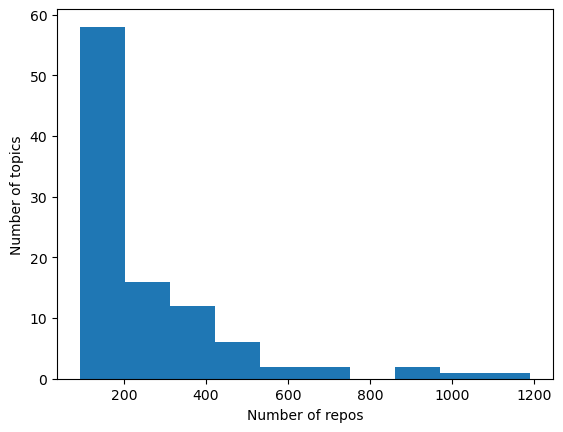

In [5]:
# Make histogram of distibution of number of repositories that share a topic

l = [(len(r),t, r) for t,r in zip(u.index, u)]
l.sort()
plt.hist([le for le, t, r in l[-100:]])
plt.ylabel('Number of topics')
plt.xlabel('Number of repos')
plt.show()

In [20]:
#create a set of edges to build of a graph from, where two topics will have an edge if the number of shared repositories is above a threshold

threshold = 20 # number of repos shared between two topics to have an edge
top_n = 50 # number of topics to look at

edges = set()
topics = [(t,le) for le,t,r in l[-top_n:]]


for l1, topic1, repo1 in l[-top_n:]:
    for l2, topic2, repo2 in l[-top_n:]:
        shared_repos = len(set(repo1)&set(repo2))
        if (topic1 != topic2) & (shared_repos>threshold) & ((topic1,topic2,shared_repos) not in edges) & ((topic2,topic1,shared_repos) not in edges):
            edges.add((topic1,topic2,shared_repos))
print('Number of edges found:', len(edges), '. Number of topics included:',top_n)           

Number of edges found: 127 . Number of topics included: 50


In [23]:
G = nx.Graph(nodes=topics)
for t, le in topics:
    G.add_node(t, name=t, size=le*0.01)

for e in edges:
    G.add_edge(e[0],e[1],weight=e[2]*5)

In [24]:
net = Network(height=800, width=800, notebook=True)
net.from_nx(G)
net.toggle_physics(True)
net.show_buttons()
net.show('example.html')

In [9]:
pos = nx.spring_layout(G)
viz = nxa.draw_networkx(G, pos=pos, width='weight', node_tooltip='name')
viz.interactive()

alt.LayerChart(...)

In [209]:
# calculate layout positions, for example using Graphviz's 'twopi' algorithm, calculated via networkx's API.  
pos = nx.random_layout(G)


# Step 2: Convert graph data from NetworkX's format to the pandas DataFrames expected by Altair

pos_df = pd.DataFrame.from_records(dict(node_id=k, x=x, y=y) for k,(x,y) in pos.items())
node_df = pd.DataFrame.from_records(dict(data, **{'node_id': n}) for n,data in G.nodes.data())
edge_data = ((dict(d, **{'edge_id':i, 'end':'source', 'node_id':s}),
              dict(d, **{'edge_id':i, 'end':'target', 'node_id':t}))
             for i,(s,t,d) in enumerate(G.edges.data()))
edge_df = pd.DataFrame.from_records(chain.from_iterable(edge_data))


# Step 3:  Use Altair to encode the graph data as marks in a visualization
x,y = alt.X('x:Q', axis=None), alt.Y('y:Q', axis=None)
# use a lookup to tie position data to the other graph data
select_repo = alt.selection_single(
     # Display the topic keyword on mouseover (assuming we grouped by topic)
     on="mouseover", nearest=True, fields=["name"], empty="none"
 )

node_position_lookup = {
    'lookup': 'node_id', 
    'from_': alt.LookupData(data=pos_df, key='node_id', fields=['x', 'y'])
}
nodes = (
    alt.Chart(node_df)
    .mark_circle(size=300, opacity=1)
    .encode(x=x, y=y, color=alt.Color('rank:N', legend=None))
    .transform_lookup(**node_position_lookup)
    .add_selection(select_repo)
)
edges = (
    alt.Chart(edge_df)
    .mark_line(color='gray')
    .encode(x=x, y=y, detail='edge_id:N')  # `detail` gives one line per edge
    .transform_lookup(**node_position_lookup)
)
chart = (
    (edges+nodes)
    .properties(width=900, height=500,)
    .configure_view(strokeWidth=0)
)
chart


alt.LayerChart(...)

In [131]:
pos_df

,node_id,x,y
0,parser,0.003877,0.030652
1,javascript,0.001589,-0.002052
2,mysql,-0.029539,-0.060230
3,sql,-0.035804,-0.044606
4,statist,-0.043925,-0.025614
...,...,...,...
95,rust,-0.058393,0.111736
96,vue,0.038750,0.002160
97,atom,0.065651,0.011766
98,test,0.700347,0.665295


In [136]:
# Was originally the background image for the airports
states = alt.topo_feature(data.us_10m.url, feature="states")

# Original example, TODO: remove
airports = data.airports.url
flights_airport = data.flights_airport.url

# Original example, TODO: remove
states = alt.topo_feature(data.us_10m.url, feature="states")

# Original example, TODO: remove
select_city = alt.selection_single(
    # Decides which blob is selected by the mouse hover-over.
    # Can maybe forgo this for the static graph
    on="mouseover", nearest=True, fields=["origin"], empty="none"
)

In [137]:
airports

'https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/airports.csv'

In [134]:
# Was originally the background image for the airports
states = alt.topo_feature(data.us_10m.url, feature="states")

# Original example, TODO: remove
airports = data.airports.url
flights_airport = data.flights_airport.url

# Original example, TODO: remove
states = alt.topo_feature(data.us_10m.url, feature="states")

# Original example, TODO: remove
select_city = alt.selection_single(
    # Decides which blob is selected by the mouse hover-over.
    # Can maybe forgo this for the static graph
    on="mouseover", nearest=True, fields=["origin"], empty="none"
)

# NEW
# Create mouseover selection
# select_repo = alt.selection_single(
#     # Display the topic keyword on mouseover (assuming we grouped by topic)
#     on="mouseover", nearest=True, fields=["topic"], empty="none"
# )


# TODO:
# It seems we have to do a mapping from topics to (self chosen) coordinates 
# to draw them in the right spots of the graph. -> build x and y to topic map somehow


# calculate layout positions  
pos = nx.spring_layout(G)
pos_df = pd.DataFrame.from_records(dict(node_id=k, x=x, y=y) for k,(x,y) in pos.items())
lookup_data = alt.LookupData(
    pos_df, key='node_id', fields=["x", "y"]
)

# TODO:
# Define which attributes to lookup from repos
# Might need to build a new dataframe joining repos and the repo_topic_relations so that we can group by topic
# lookup_data = alt.LookupData(
#     # We have to actually build x and y first!
#     repos, key="iata", fields=["topic", "x", "y"]
#     # Don't quite know what key 'iata' is
# )


# TODO: Need to change the background to maybe just white instead of the united states
background = alt.Chart(states).mark_geoshape(
    fill="lightgray",
    stroke="white"
).properties(
    width=750,
    height=500
).project("albersUsa")

# TODO: Probably need to change lat and long to x and y defined above
# This should be the actual network edges
# We need to build another dataframe that connects topics that share 
# a certain amount of contributers between them (have to go over their 
# contributed repositories)
edges = alt.Chart(edge_df).mark_rule(opacity=0.35).encode(
    latitude="latitude:Q",
    longitude="longitude:Q",
    latitude2="lat2:Q",
    longitude2="lon2:Q"
).transform_lookup(
    # origin and destination have to be chosen from that new dataframe
    # where the topics with enough support are connected
    lookup="origin",
    from_=lookup_data
).transform_lookup(
    lookup="destination",
    from_=lookup_data,
    as_=["state", "lat2", "lon2"]
).transform_filter(
    select_city
)

# TODO: Again need to change lat and long to x and y defined above
nodes = alt.Chart(flights_airport).mark_circle().encode(
    latitude="latitude:Q",
    longitude="longitude:Q",
    # TODO: Do the sizing according to the amount of repos corresponding to the topic
    size=alt.Size("routes:Q", scale=alt.Scale(range=[0, 1000]), legend=None),
    order=alt.Order("routes:Q", sort="descending"),
    # TODO: Change tooltip to the topic name and amount of repos corresponding to it
    tooltip=["origin:N", "routes:Q"]
).transform_aggregate(
    # TODO: Count repos
    routes="count()",
    # TODO: Grouped by topic
    groupby=["origin"]
).transform_lookup(
    # TODO: Lookup repo name
    lookup="origin",
    from_=lookup_data
).transform_filter(
    # Probably not needed
    (alt.datum.state != "PR") & (alt.datum.state != "VI")
).add_selection(
    select_city
)

# Combine the different graphs
(background + connections + points).configure_view(stroke=None)

alt.LayerChart(...)

#### Second visualization: Topics as nodes and connections by shared contributors

In [29]:
# Read our cleaned data
repos = pd.read_csv('../cleaned_data/repo_info_stop75.csv', index_col=0)
contributors = pd.read_csv('../raw_data/10_contributor_info_all.csv', index_col=0)
repo_contrib_relation = pd.read_csv('../raw_data/repo_contributor_relationship_table_all.csv', index_col=0)
repo_topic_relation = pd.read_csv('../cleaned_data/topic_relationship_table_stop75.csv', index_col=0).reset_index(drop=True)

In [37]:
#get list of repos for each simplified topic
u = repo_topic_relation.groupby("topic_simple")["id"].agg(list)

#get list of contributors for each repo
v = repo_contrib_relation.groupby("Repo")['Contributor'].agg(list)
repo_contrib_dict = dict(zip(v.index,v))

In [58]:
#get list of topics to contributors
l = list()
for t,r in zip(u.index, u):
    current_t = []
    for repo in r:
        if repo in repo_contrib_dict:
            current_t = current_t + repo_contrib_dict[repo]
    l.append((t,set(current_t)))
l = [(len(c),t,c) for t,c in l]
l.sort()

In [73]:
#create a set of edges to build of a graph from, where two topics will have an edge if the number of shared contributors is above a threshold

threshold = 200 # number of repos shared between two topics to have an edge
top_n = 40 # number of topics to look at

edges = set()
topics = [(t,le) for le,t,r in l[-top_n:]]


for l1, topic1, repo1 in l[-top_n:]:
    for l2, topic2, repo2 in l[-top_n:]:
        shared_repos = len(set(repo1)&set(repo2))
        if (topic1 != topic2) & (shared_repos>threshold) & ((topic1,topic2,shared_repos) not in edges) & ((topic2,topic1,shared_repos) not in edges):
            edges.add((topic1,topic2,shared_repos))
print('Number of edges found:', len(edges), '. Number of topics included:',top_n)           

Number of edges found: 81 . Number of topics included: 40


In [75]:
G = nx.Graph(nodes=topics)
for t, le in topics:
    G.add_node(t, name=t, size=le*0.005)

for e in edges:
    G.add_edge(e[0],e[1],width=e[2]/200)
    
net = Network(height=800, width=800, notebook=True)
net.from_nx(G)
net.toggle_physics(True)
net.show_buttons()
net.show('example.html')